# To Fish or Not to Fish
> "A PyTorch tutorial for dealing with Custom Image Data"

- toc: true
- branch: master
- badges: true
- comments: false
- categories: [PyTorch, DataLoaders, Image Manipulation]
- image: images/tofish.jpg
- hide: false
- search_exclude: true

## Importing Data from Kaggle to Colab

I collected the [Fish Dataset](https://www.kaggle.com/crowww/a-large-scale-fish-dataset) from Kaggle into a Google Colab Notebook. I have used the steps that were suggested in this [link](https://www.kaggle.com/general/156610)  for downloading data into a Colab environment.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files

files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!pwd

/content


In [6]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

100% 3.24G/3.24G [01:00<00:00, 35.5MB/s]
100% 3.24G/3.24G [01:00<00:00, 57.4MB/s]


In [ ]:
!unzip a-large-scale-fish-dataset.zip

## Libraries

In [8]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sklearn
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import PIL
from PIL import Image

import time
import seaborn as sns
import glob
from pathlib import Path
torch.manual_seed(1)
np.random.seed(1)

## Image Analysis

### Step-1: Defining Folder Path

1. We select the folder which contains images of Fishes in PNG format.    
2. We separate actual images from segmented images.
3. We save the classes in an integer format(can be used later for Data Classification)

In [9]:
data_path = Path.cwd()/'Fish_Dataset/Fish_Dataset'

# Path for all the files in a 'png' format.
image_path = list(data_path.glob('**/*.png')) 

# Separate Segmented from Non-Segmented Images

non_segmented_images = [img for img in image_path if 'GT' not in str(img)]
labels_non_segment = [img.parts[-3] for img in non_segmented_images]

segmented_images = [img for img in image_path if 'GT' in str(img)]
lables_segment = [img.parts[-3] for img in segmented_images]

classes = list(set(lables_segment))

# Convert String Labels to int

int_classes = {fish:i for i,fish in enumerate(classes)}

lables = [int_classes[lable] for lable in labels_non_segment]

### Step-2: Opening an Image

Fish Class:Shrimp


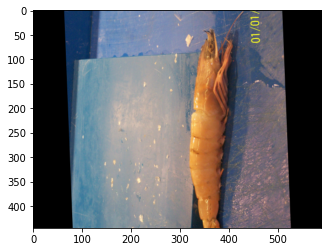

In [10]:
## Open an Image
print(f"Fish Class:{classes[image_data.labels[200]]}")
# Image.open(image_data.Path[150])
img1 = Image.open(image_data.Path[200])
plt.imshow(img1)

## Image Augmentation

In [13]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T

torch.manual_seed(0)


def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
  """
  Official PyTorch source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
  """
  if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
    imgs = [imgs]

  num_rows = len(imgs)
  num_cols = len(imgs[0]) + with_orig
  fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
  for row_idx, row in enumerate(imgs):
    row = [orig_img] + row if with_orig else row
    for col_idx, img in enumerate(row):
      ax = axs[row_idx, col_idx]
      ax.imshow(np.asarray(img), **imshow_kwargs)
      ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

  if with_orig:
    axs[0, 0].set(title='Original image')
    axs[0, 0].title.set_size(8)
  if row_title is not None:
    for row_idx in range(num_rows):
      axs[row_idx, 0].set(ylabel=row_title[row_idx])

  plt.show()

### Padding

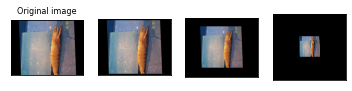

In [15]:
orig_img = img1
padded_imgs = [T.Pad(padding=padding)(orig_img) for padding in (10,100,500)]
plot(padded_imgs)

### Resizing

In [27]:
resized_imgs = [T.Resize(size=s)(orig_img) for s in ((100,100),(200,200),(280,280), (1000,1000))]

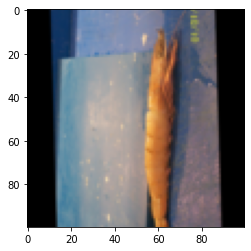

In [28]:
# Observe the x and y scale
plt.imshow(resized_imgs[0])

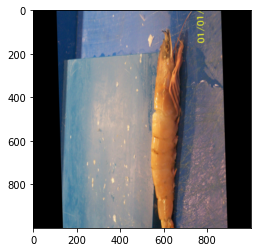

In [29]:
# The x and y scale is in the range of 1000
plt.imshow(resized_imgs[-1])

### Adding Jitters

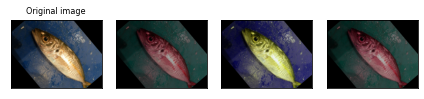

In [ ]:
jitter = T.ColorJitter(brightness=.5, hue=.3)
jitted_imgs = [jitter(orig_img) for _ in range(3)]
plot(jitted_imgs)

### Flipping

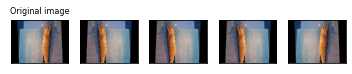

In [44]:
horiflip = T.RandomHorizontalFlip(p=0.5)

hor_flip_img = [horiflip(orig_img) for _ in range(4)]
plot(hor_flip_img)

## Data Preparation for Modeling

- Firstly, create a dataframe with 'Image Path' and the 'Image Label' against the 'Image Path'

In [31]:
image_data = pd.DataFrame({'Path': non_segmented_images,\
              'labels': lables})

- Create a Custom class to upload the data.
- The class should be able to implement Transformation on an individual image.

In [32]:
class FishDataset(Dataset):
  """Class for loading an Image."""
  def __init__(self, images, labels, transform = None):
    self.images = images
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    img = Image.open(self.images.iloc[idx])

    if self.transform:
      img = self.transform(img)
    label = self.labels.iloc[idx]
    return img, label

- Now Apply Transformation:
  - When augmenting an Image, we do not want to apply any randomness to unseen or Test data. Thus, we always go for transforming Train and Test differently.

In [33]:
##########################
### FISH DATASET
##########################

train_transform = transforms.Compose([transforms.Resize((64,64)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

test_transforms = transforms.Compose([transforms.Resize((64,64)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


### Prepare Data Loaders

In [34]:
def get_loaders(train, train_labels, val, val_labels,test, test_labels, batch_size, num_workers, train_transform, test_transform):
  """
  Returns the Train, Validation and Test DataLoaders.
  """

  train_ds = FishDataset(images = train, labels = train_labels, transform = train_transform)
  val_ds = FishDataset(images = val, labels = val_labels, transform = test_transforms)
  test_ds = FishDataset(images = test, labels = test_labels, transform = test_transforms)

  train_loader = DataLoader(train_ds, batch_size=batch_size,num_workers=num_workers,
                            shuffle= True)
  val_loader = DataLoader(val_ds, batch_size=batch_size,num_workers=num_workers,
                            shuffle= False)
  test_loader = DataLoader(test_ds, batch_size=batch_size,num_workers=num_workers,
                          shuffle= False)
  return train_loader, val_loader, test_loader

## Create Train,Test and Validation Sets

In [36]:
RANDOM_SEED = 123
BATCH_SIZE = 128
NUM_EPOCHS = 10
WORKERS = 2 # Suggested for COlab
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [38]:
# Perform Train/Val/Test Split
train,test, train_labels, test_labels = train_test_split(image_data.Path, image_data.labels, test_size=0.2, shuffle=True)

train,val, train_labels, val_labels = train_test_split(train, train_labels, test_size=0.2, shuffle=True)

In [39]:
## Create Data Loaders
train_loader, val_loader, test_loader = get_loaders(train,train_labels,val, val_labels, test,test_labels, BATCH_SIZE,WORKERS,
                                                    train_transform, test_transforms)

- Lets observe the Shape of Train/Val/Test Data

In [41]:
#collapse_show
## Training Data
for (image,label) in train_loader:
  print(image.shape)
  print(label.shape)
  break

torch.Size([128, 3, 64, 64])
torch.Size([128])


In [42]:
#collapse_show
## Validation Data
for (image,label) in val_loader:
  print(image.shape)
  print(label.shape)
  break

torch.Size([128, 3, 64, 64])
torch.Size([128])


In [43]:
#collapse_show
# Test Data
for (image,label) in test_loader:
  print(image.shape)
  print(label.shape)
  break

torch.Size([128, 3, 64, 64])
torch.Size([128])


- We observe that the dimensions of Train,Test and Validation are consistent.
- We were able to transform images in the required format.
- Each imput image consisted of 3 channels and each channel was (64,64) in size.